In [1]:
import random 
import math

import numba
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# from madigan.environments import make_env
from madigan.environments.cpp import Broker, Synth, Env as EnvC
from madigan.environments.cpp import Assets, RiskInfo, EnvInfoMulti, EnvInfoSingle

from madigan.fleet import make_agent

from madigan.utils.preprocessor import make_preprocessor as _make_preprocessor
from madigan.utils import make_config, State
from madigan.utils import ReplayBuffer, SARSD, DiscreteActionSpace
from madigan.utils import list_2_dict, reduce_train_metrics


from madigan.run.test import test
from madigan.utils.plotting import plot_test_metrics

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        test_steps=1_000,
        nsteps=1_000_000,
    
        assets=["sine1"],
#         data_source_type="Triangle",
#         generator_params={
#         'freq':[2.],
#         'mu':[0.6],
#         'amp':[.5],
#         'phase':[0.],
#         'dX':0.1,
#         "noise": 0.0},
        data_source_type="SineAdder",
        generator_params={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},
        preprocessor_type="Custom",
        window_length=64,
    
        agent_type = "DQN",
        discrete_actions=True,
        discrete_action_atoms=2,
        double_dqn=True,
        nstep_return = 3,
        target_update_freq=12000,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=32,
        discount = 0.999,
        lot_unit_value=100_000,
    
    
        model_class="ConvModel",
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.0,
 'env_type': 'Synth',
 'data_source_type': 'SineAdder',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [2.2, 4.1, 1.0, 3.0],
  'mu': [0.6, 0.3, 2.0, 4.2],
  'amp': [0.5, 0.2, 0.4, 1.2],
  'phase': [0.0, 1.0, 4.0, 0.0],
  'dX': 0.01,
  'noise': 0.0},
 'assets': ['sine1'],
 'lot_unit_value': 100000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 2,
 'preprocessor_type': 'Custom',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'DQN',
 'nsteps': 1000000,
 'test_steps': 1000,
 'rb_size': 100000,
 'min_rb_size': 50000,
 'train_freq': 4,
 'target_update_freq': 12000,
 'test_freq': 32000,
 'log_freq': 10000,
 'model_save_freq': 64000,
 'min_tf': 64,
 'batch_size': 32,
 'agent_config': {'type': 'DQN',
  'basepath': '/media/hem

## Env

In [3]:
@numba.njit
def ternarize_array(arr):
    arr[arr<0.] = -1.
    arr[arr==0.] = 0.
    arr[arr>0.] = 1.
    return arr
ara = np.random.randn(10)
ternarize_array(ara)
ara

array([-1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1.])

In [4]:
class EnvBinary:
    def __init__(self, config):
        self.assets = Assets(config.assets)
        self.broker = Broker(config.experiment_id, self.assets, config.init_cash)
        self._dataSource = Synth(config)
        
        self.lot_unit = config.lot_unit_value
        self.action_atoms = config.discrete_action_atoms
        self.config = config
        
        self.broker.setDataSource(self._dataSource)
        self.broker.setRequiredMargin(config.required_margin)
        self.broker.setMaintenanceMargin(config.maintenance_margin)
        
        self.position_length = 0
        
    def reset(self):
        self.broker = Broker(self.config.experiment_id, self.assets, 
                            self.config.init_cash)
        self._dataSource = Synth(self.config)
        self.broker.setDataSource(self._dataSource)
        self.broker.setRequiredMargin(config.required_margin)
        self.broker.setMaintenanceMargin(config.maintenance_margin)
        
        return State(self.currentPrices, self.ledgerTernary, 0)

    @property
    def dataSource(self):
        return self._dataSource
    
    @property
    def currentPrices(self):
        return self._dataSource.currentData()
    
    @property
    def portfolio(self):
        return self.broker.portfolio()
    
    @property
    def ledger(self):
        return self.portfolio.ledger
    
    @property
    def ledgerNormed(self):
        return self.ledgerTernary
    
    @property
    def ledgerTernary(self):
        ledger = np.array(self.ledger, copy=True)        
        return ternarize_array(ledger)
    
    @property
    def equity(self):
        return self.portfolio.equity
    
    @property
    def cash(self):
        return self.portfolio.cash
    
    @property
    def availableMargin(self):
        return self.portfolio.availableMargin
    
    @property
    def pnl(self):
        return self.portfolio.pnl
    
    def step(self, actions: np.ndarray = None):
        """
        If actions is None, no transaction is attempted and dataSource is iterated to
        get new prices
        If actions is passed, a transaction/s is attempted. Can only Reverse Positions, not add to 
        or close.
        Hence EnvBinary.
        """

        if actions is None: # no transaction
            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = (newEq-prevEq) / prevEq
            risk = self.portfolio.checkRisk()
            done = False if risk == RiskInfo.green else True
            
            return (State(newPrices, self.ledgerTernary,
                          self.dataSource.currentTime),
                    reward, done, EnvInfoMulti())
        else:
            if not isinstance(actions, np.ndarray):
                raise TypeError("action must be an np array")
            
            prevEq = self.portfolio.equity
            
            ledger_ternary = self.ledgerTernary
            actions_binary = 2*actions - 1
            actions_binary[ledger_ternary == actions_binary] = 0.
            transactions = actions_binary * self.lot_unit
            
            exiting = False
            assets = np.where(transactions!=0.)[0]
            for i, asset in enumerate(assets): # implicit if len(assets)
                if self.ledger[i] != 0:
                    exiting = True
                    prev_pnl = self.portfolio.pnl / (np.abs(self.portfolio.meanEntryValue).sum()+1e-7)
                    print("CLOSING")
                self.broker.close(int(asset))
                
            print("="*80)
            print("-"*80)
            print("Pre Transaction")
            print("pnl", self.portfolio.pnl)
            print("mean entry val", np.abs(self.portfolio.meanEntryValue).sum())
            print("mean entry price", self.portfolio.meanEntryPrices)
            print("ledger", self.ledger)
            broker_response_multi = self.broker.handleTransaction(transactions)
            
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = (self.portfolio.pnl / (np.abs(self.portfolio.meanEntryValue).sum()+1e-7))
            
            print("-"*80)
            print("Post Transaction")
            print("pnl", self.portfolio.pnl)
            print("mean entry val", np.abs(self.portfolio.meanEntryValue).sum())
            print("mean entry price", self.portfolio.meanEntryPrices)
            print("ledger", self.ledger)
            print("reward", reward)
            print("="*80)
  
            reward *= 0.01
            
            done = False
            if broker_response_multi.marginCall:
                done=True
            for _risk in broker_response_multi.riskInfo:
                if _risk != RiskInfo.green:
                    done = True
            if exiting:
                done = True
                reward = 0.01 * prev_pnl
            return (State(newPrices, self.ledgerTernary,
                          self.dataSource.currentTime),
                    reward, done, EnvInfoMulti(broker_response_multi))
     
    @numba.jit
    def actions_to_transactions(self, actions):
        pass
        

In [164]:
from dataclasses import dataclass

@dataclass
class BrokerResponse:
    event: str
    timestamp: int
    transPrice: float
    transUnits: float
    transCost: float
    riskInfo: object
    marginCall: bool

@dataclass
class EnvInfo:
    brokerResponse: BrokerResponse
    exiting: bool
        
class EnvBinary(EnvC):
    def step(self, actions: np.ndarray = None):
        """
        If actions is None, no transaction is attempted and dataSource is iterated to
        get new prices
        If actions is passed, a transaction/s is attempted. Can only Reverse Positions, not add to 
        or close.
        Hence EnvBinary.
        """

        if actions is None: # no transaction
            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = (newEq-prevEq) / prevEq
            risk = self.portfolio.checkRisk()
            done = False if risk == RiskInfo.green else True

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(BrokerResponse("", 0, 0., 0., 0., 
                                                             risk, done), False))
        else:
            if not isinstance(actions, np.ndarray):
                raise TypeError("action must be an np array")

            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = newEq / prevEq 
            reward = math.log(reward)

            
            ledger_ternary = self.ledgerTernary
            actions_ternary = 2*actions - 1
            actions_ternary[ledger_ternary == actions_ternary] = 0.
            units = (0.2*self.availableMargin) / self.currentPrices
            transactions = actions_ternary * units

#             exiting = False
            assets = np.where(transactions!=0.)[0]
            for i, asset in enumerate(assets): # implicit if len(assets)
                if self.ledger[i] != 0:
#                     exiting = True
                    self.broker.close(int(asset))
                reward -= self.transaction_cost_rel
            broker_response_multi = self.broker.handleTransaction(transactions)
            
            done = False
            if broker_response_multi.marginCall:
                done=True
            for _risk in broker_response_multi.riskInfo:
                if _risk != RiskInfo.green:
                    done = True
#             if exiting:
#                 done = True
            if self.equity < 0.1 * self.portfolio.initCash:
                done = True
                print('equity: ', self.equity)

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(broker_response_multi, 0.))

    @property
    def ledgerTernary(self):
        ara = np.array(self.ledger, copy=True)
        return ternarize_array(ara)
    

In [165]:
# class EnvBinary_1:
#     def __init__(self, config):
#         self.assets = Assets(config.assets)
#         self._env = EnvC("Synth", self.assets, config.init_cash)
#         self.lot_unit = config.lot_unit_value
#         self.action_atoms = config.discrete_action_atoms
#         self.config = config
        
#         self.broker.setRequiredMargin(config.required_margin)
#         self.broker.setMaintenanceMargin(config.maintenance_margin)
        
        
#         self.position_length = 0

#     def reset(self):
#         return self._env.reset()

#     @property
#     def dataSource(self):
#         return self._env.dataSource
    
#     @property
#     def broker(self):
#         return self._env.broker
    
#     @property
#     def portfolio(self):
#         return self._env.portfolio
    
#     @property
#     def currentPrices(self):
#         return self.dataSource.currentData()
    
#     @property
#     def ledger(self):
#         return self.portfolio.ledger
    
#     @property
#     def ledgerNormed(self):
#         return self.ledgerTernary
    
#     @property
#     def ledgerTernary(self):
#         ledger = np.array(self.ledger, copy=True)        
#         return ternarize_array(ledger)
    
#     @property
#     def equity(self):
#         return self.portfolio.equity
    
#     @property
#     def cash(self):
#         return self.portfolio.cash
    
#     @property
#     def availableMargin(self):
#         return self.portfolio.availableMargin
    
#     @property
#     def pnl(self):
#         return self.portfolio.pnl
    
#     def step(self, actions: np.ndarray = None):
#         """
#         If actions is None, no transaction is attempted and dataSource is iterated to
#         get new prices
#         If actions is passed, a transaction/s is attempted. Can only Reverse Positions, not add to 
#         or close.
#         Hence EnvBinary.
#         """

#         if actions is None: # no transaction
#             prevEq = self.portfolio.equity
#             newPrices = self.dataSource.getData()
#             newEq = self.portfolio.equity
#             reward = (newEq-prevEq) / prevEq
#             risk = self.portfolio.checkRisk()
#             done = False if risk == RiskInfo.green else True
            
#             return (State(newPrices, self.ledgerTernary,
#                           self.dataSource.currentTime),
#                     reward, done, EnvInfoMulti())
#         else:
#             if not isinstance(actions, np.ndarray):
#                 raise TypeError("action must be an np array")
            
#             prevEq = self.portfolio.equity
            
#             ledger_ternary = self.ledgerTernary
#             actions_binary = 2*actions - 1
#             actions_binary[ledger_ternary == actions_binary] = 0.
#             transactions = actions_binary * self.lot_unit
            
#             exiting = False
#             assets = np.where(transactions!=0.)[0]
#             for i, asset in enumerate(assets): # implicit if len(assets)
#                 if self.ledger[i] != 0:
#                     exiting = True
#                     prev_pnl = self.portfolio.pnl / (np.abs(self.portfolio.meanEntryValue).sum()+1e-7)
#                 self.broker.close(int(asset))
                
#             print("="*80)
#             print("-"*80)
#             print("Pre Transaction")
#             print("pnl", self.portfolio.pnl)
#             print("mean entry val", np.abs(self.portfolio.meanEntryValue).sum())
#             print("mean entry price", self.portfolio.meanEntryPrices)
#             print("ledger", self.ledger)
#             broker_response_multi = self.broker.handleTransaction(transactions)
            
#             newPrices = self.dataSource.getData()
#             newEq = self.portfolio.equity
#             reward = (self.portfolio.pnl / (np.abs(self.portfolio.meanEntryValue).sum()+1e-7))
            
#             print("-"*80)
#             print("Post Transaction")
#             print("pnl", self.portfolio.pnl)
#             print("mean entry val", np.abs(self.portfolio.meanEntryValue).sum())
#             print("mean entry price", self.portfolio.meanEntryPrices)
#             print("ledger", self.ledger)
#             print("reward", reward)
#             print("="*80)
  
#             reward *= 0.01
            
#             done = False
#             if broker_response_multi.marginCall:
#                 done=True
#             for _risk in broker_response_multi.riskInfo:
#                 if _risk != RiskInfo.green:
#                     done = True
#             if exiting:
#                 done = True
#                 reward = 0.01 * prev_pnl
#             return (State(newPrices, self.ledgerTernary,
#                           self.dataSource.currentTime),
#                     reward, done, EnvInfoMulti(broker_response_multi))
     
#     @numba.jit
#     def actions_to_transactions(self, actions):
#         pass
        

In [166]:
def make_env(config):
    assets = Assets(config.assets)
    env = EnvBinary(config.data_source_type, assets, config.init_cash, config)
    env.lot_unit = config.lot_unit_value
    env.action_atoms = config.discrete_action_atoms
    env.transaction_cost_rel = config.transaction_cost_rel
#     env.setTransactionCost
    return env

In [167]:
# env = EnvBinary(config)
# assets = Assets(config.assets)
env = make_env(config)
srdi = env.step(np.array([1]))
print('reward:', srdi[1])
print('reward:', env.step()[1])
env.step(np.array([0]))
env.reset()
print(env.currentPrices, env.cash, env.equity, env.ledger, env.availableMargin)

reward: 0.0
reward: 0.008888846536687343
[7.21755705] 1000000.0 1000000.0 [0.] 1000000.0


In [168]:
from collections import deque
import sklearn.preprocessing

class Preprocessor:
    def __init__(self, window_len):
        self.k = window_len
        self.min_tf = self.k
        self.price_buffer = deque(maxlen=self.k)
        self.portfolio_buffer = deque(maxlen=self.k)
        self.time_buffer = deque(maxlen=self.k)
        self.feature_output_size = 12

    def __len__(self):
        return len(self.price_buffer)

    def stream_srdi(self, srdi):
        self.price_buffer.append(srdi[0].price)
        self.portfolio_buffer.append(srdi[0].portfolio)
        self.time_buffer.append(srdi[0].timestamp)

    def stream_state(self, state):
        self.price_buffer.append(np.array(state.price, copy=True))
        self.portfolio_buffer.append(np.array(state.portfolio, copy=True))
        self.time_buffer.append(np.array(state.timestamp, copy=True))

    def stream(self, data):
        if isinstance(data, tuple): # assume srdi
            self.stream_srdi(data)
        elif isinstance(data, (StateA, State)):
            self.stream_state(data)

    def current_data(self):
        prices = np.array(self.price_buffer, copy=True)
        prices = sklearn.preprocessing.minmax_scale(prices)
        features = np.empty(self.feature_output_size)
        for i, window in enumerate([3, 5, 7, 11]):
            features[i] = np.mean(prices[-window:])
            features[i+4] = np.var(prices[-window:])
        features[8] = prices.min()
        features[9] = prices.max()
        features[10] = prices[0]
        features[11] = prices[-1]
        return State(features.reshape(-1, 1) ,
                     self.portfolio_buffer[-1],
                     self.time_buffer[-1])

    def initialize_history(self, env):
        while len(self) < self.k:
            _state, reward, done, info = env.step()
            self.stream_state(_state)


In [169]:
def make_preprocessor(config):
    if config.preprocessor_type == "Custom":
        return Preprocessor(config.preprocessor_config.window_length)
    return _make_preprocessor(config)

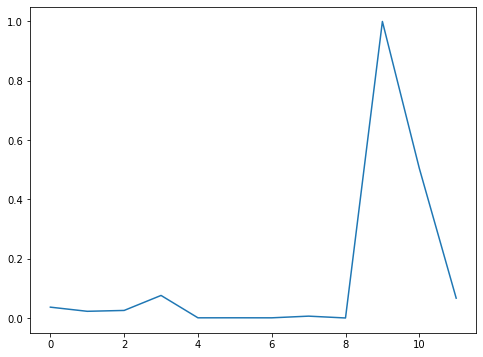

In [170]:
from IPython.core.pylabtools import figsize
figsize(8, 6)

preprocessor = make_preprocessor(config)
env.currentPrices
preprocessor.initialize_history(env)
plt.plot(preprocessor.current_data().price)
env.reset()

## Agent

In [171]:
from madigan.utils import DiscreteRangeSpace, DiscreteActionSpace

class AgentLM:
    def __init__(self, config, feature_input_size, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.action_atoms = config.discrete_action_atoms
        self.lot_unit_value = config.lot_unit_value
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
#         self._action_space = DiscreteActionSpace(actions, probs, len(config.assets))
        self._action_space = DiscreteRangeSpace((0, 2), len(config.assets))

#         input_size = config.preprocessor_config.window_length + len(config.assets)
        input_size = feature_input_size + len(config.assets)
        self.model_b = nn.Linear(input_size, self.action_atoms).to(device).float()
        self.model_t = nn.Linear(input_size, self.action_atoms).to(device).float()
        
        self.discount = config.agent_config.discount
        
        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.agent_config.optim_config.lr)
        
        self.tau_soft = config.agent_config.tau_soft
        self.config = config
        
    @property
    def action_space(self):
        return self._action_space
    
    def prep_state(self, x):
        price = x.price[None, ..., 0]
        x = np.concatenate([price, x.portfolio[None, ...]], axis=-1)
        return torch.from_numpy(x).float().to(self.device)
    
    def get_qvals(self, x):
        x = self.prep_state(x)
        return self.model_t(x).detach()
    
    def action_to_transaction(self, actions):
#         return self.lot_unit_value * (actions - (self.action_atoms // 2)).cpu().numpy()
        return actions.cpu().numpy()
        
    def __call__(self, x):
        with torch.no_grad():
            x = self.prep_state(x)
            qvals = self.model_t(x)
            actions = qvals.max(-1)[1]
            return self.action_to_transaction(actions)
        
    def prep_sarsd(self, sarsd):
        state = State(
            price = torch.as_tensor(sarsd.state.price[..., 0], 
                                    dtype=torch.float32).to(self.device),
            portfolio = torch.as_tensor(sarsd.state.portfolio, 
                                        dtype=torch.float32).to(self.device),
            timestamp = sarsd.state.timestamp
        )
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = sarsd.action
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = State(
            price = torch.as_tensor(sarsd.next_state.price[..., 0], 
                                    dtype=torch.float32, device=self.device),
            portfolio = torch.as_tensor(sarsd.next_state.portfolio, 
                                        dtype=torch.float32, device=self.device),
            timestamp = sarsd.next_state.timestamp
        )
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        state = torch.cat([state.price, state.portfolio], dim=-1)
        next_state = torch.cat([next_state.price, next_state.portfolio], dim=-1)
        return state, action, reward, next_state, done
    
    def loss_fn(self, Qt, Gt):
        return F.smooth_l1_loss(Qt, Gt)
    
    def train_step(self, sarsd):
        state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        self.opt.zero_grad()
        with torch.no_grad():
            greedy_qvals_next = self.model_t(next_state).max(-1)[0]
            Gt = reward + (~done*self.discount * greedy_qvals_next)
        action_mask = F.one_hot(action, self.action_atoms).to(self.device)
        qvals = self.model_b(state)
        Qt = (qvals*action_mask).sum(-1)
        
        loss = self.loss_fn(Qt, Gt)
        loss.backward()
        self.opt.step()
        
        td_error = (Gt-Qt).abs().mean().detach().item()
        
        self.update_target()
        
        return {'loss': loss.detach().item(), 'td_error': td_error, 'Qt': Qt.detach(), 'Gt': Gt.detach()}
    
    def update_target(self):
        """
        Soft Update 
        """
        for behaviour, target in zip(self.model_b.parameters(), self.model_t.parameters()):
            target.data.copy_(self.tau_soft * behaviour.data + (1.-self.tau_soft)*target.data)
#         self.model_t.load_state_dict(self.model_b.state_dict())
        

In [172]:
class AgentMLP(AgentLM):
    def __init__(self, config, feature_input_size, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
 
        self.action_atoms = config.discrete_action_atoms
        self.lot_unit_value = config.lot_unit_value
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
#         self._action_space = DiscreteActionSpace(actions, probs, len(config.assets))
        self._action_space = DiscreteRangeSpace((0, 2), len(config.assets))

        input_size = feature_input_size + len(config.assets)
        d_model = config.agent_config.model_config.d_model
        self.model_b = nn.Sequential(nn.Linear(input_size, d_model), nn.ReLU(), 
                                     nn.Linear(d_model, self.action_atoms)).to(device).float()
        self.model_t = nn.Sequential(nn.Linear(input_size, d_model), nn.ReLU(), 
                                     nn.Linear(d_model, self.action_atoms)).to(device).float()
        
        self.discount = config.agent_config.discount
        
        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.agent_config.optim_config.lr)
        self.tau_soft = config.agent_config.tau_soft
        self.config = config


In [173]:
class ConvModel(nn.Module):
    def __init__(self, config, feature_input_size):
        super().__init__()
        
    def forward(self, state):
        price = state.price
        portfolio = state.portfolio
        
        
class AgentCNN(AgentMLP):
    def __init__(self, config, feature_input_size, device=None):
        super().__init__(config, feature_input_size, device)
        self.model_b = nn.Sequential(nn.Conv1d(1, 32, 5), nn.ReLU(), nn.Conv1d(32, 64, 5),
                                     nn.ReLU(), nn.Flatten(), 
                                     nn.Linear(feature_input_size8,self.action_atoms)
                                    ).to(device).float()
        self.model_b = nn.Sequential(nn.Conv1d(1, 32, 5), nn.ReLU(), nn.Conv1d(32, 64, 5),
                                     nn.ReLU(), nn.Flatten(), 
                                     nn.Linear(feature_input_size8,self.action_atoms)
                                    ).to(device).float()
    def prep_state(self, x):
        price = torch.from_numpy(x.price[None, ...])
        port = torch.from_numpy(x.portfolio)
        return 

In [174]:
class PerfectAgent:
    def __init__(self, config):
        self.config=config
        self.action_atoms = config.discrete_action_atoms
        self.params = self.config.generator_params
        
    def get_qvals(self, state):
        prices = state.price
        if self.config.data_source_type in  ("Synth", "Triangle"):
            if prices[-3] < prices[-2] > prices[-1]:
                return torch.tensor([[-1., 1.]])
            elif prices[-3] > prices[-2] < prices[-1]:
                return torch.tensor([[1., -1.]])
            else:
                return torch.randn((1, 2))
        elif self.config.data_source_type == "SawTooth":
            _max = np.array(self.params['amp']) + np.array(self.params['mu'])
            if (_max - prices[-1] ) > (_max/1.25):
                return torch.tensor([[1., -1.]])
            return torch.tensor([[-1., 1.]])

    def __call__(self, state):
        qvals = self.get_qvals(state)
        if qvals[0, 1] > qvals[0, 0]:
            return np.array([1])
        return np.array([0])

In [175]:
agent = AgentLM(config, preprocessor.feature_output_size, device=device)
x = preprocessor.current_data()
qvals = agent.get_qvals(x)
action = agent(x)
print(qvals, action)

tensor([[ 0.0482, -0.1985]], device='cuda:0') [0]


## Training


In [176]:
def trainer(agent, env, preprocessor, config):
    rb = ReplayBuffer(config.rb_size)
    nstep_buffer = []
    nstep=config.nstep_return
    min_rb_size = config.min_rb_size
    target_update_freq = config.target_update_freq
    perfect_agent = PerfectAgent(config)

    
    eps = 1.
    eps_decay = config.expl_eps_decay
    eps_min = config.expl_eps_min
    env.reset()
    preprocessor.initialize_history(env)
    state = preprocessor.current_data()
    i = 0
    running_reward = 0.
    while True:
        trn_metrics=None
        
        if random.random() < eps:
            
#             curPos = env.ledgerTernary
#             if curPos[0] > 0.:
#                 if random.random() < 0.1:
#                     actions = np.array([0])
#                 else:
#                     actions = np.array([1])
#             elif curPos[0] < 0.:
#                 if random.random() < 0.1:
#                     actions = np.array([1])
#                 else:
#                     actions = np.array([0])
#             else:
#             if random.random() < 0.2:
#                 actions = perfect_agent(state)
#             else:
# #                 actions = random.sample([-config.lot_unit_value, 0, config.lot_unit_value], 1)
            actions = np.random.randint(0, 2, 1)
        else:
            actions = agent(state)
        eps = max(eps_min, eps*eps_decay)
        
#         Prevent double positon
        for i, action in enumerate(actions):
            if np.sign(action) == np.sign(env.ledger):
                actions[i] = 0.
                
        _next_state, reward, done, info = env.step(actions)
#         reward = max(-1., min(reward, 1.))
        preprocessor.stream_state(_next_state)
        next_state = preprocessor.current_data()
        
        sarsd = SARSD(state, actions, reward, next_state, done)
        nstep_buffer.append(sarsd)
        if len(nstep_buffer) == nstep:
            _reward = sum([dat.reward for dat in nstep_buffer])
#             _next_state = nstep_buffer[-1].next_state
            nstep_sarsd = nstep_buffer.pop(0)
            nstep_sarsd.reward = _reward
            rb.add(nstep_sarsd)
            running_reward += _reward
        
        if done:
            env.reset()
            preprocessor.initialize_history(env)
            state = preprocessor.current_data()
            print('running_reward: ', running_reward)
            running_reward = 0.
        else:
            state = next_state
        if len(rb) >= min_rb_size:
            sarsd = rb.sample(config.batch_size)
            trn_metrics = agent.train_step(sarsd)
            trn_metrics['eps'] = eps
            trn_metrics['running_reward'] = running_reward
#         if i % target_update_freq == 0:
#             agent.model_t.load_state_dict(agent.model_b.state_dict())
            
        yield trn_metrics
        i += 1

In [177]:
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        transaction_cost_rel=0.01,
    
    
        test_steps=1_000,
        nsteps=1_000_000,
    
        assets=["sine1"],
#         data_source_type="Triangle",
#         generator_params={
#         'freq':[2.],
#         'mu':[0.6],
#         'amp':[.5],
#         'phase':[0.],
#         'dX':0.1,
#         "noise": 0.0},
        data_source_type="SineAdder",
        generator_params={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},
        preprocessor_type="Custom",
        window_length=64,
    
        agent_type = "DQN",
        discrete_actions=True,
        discrete_action_atoms=2,
        double_dqn=True,
        nstep_return = 5,
        target_update_freq=1200,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=32,
        discount = 0.999,
        lot_unit_value=10_000,
        tau_soft=1e-4,
    
        expl_eps_decay=0.999999,
    
        model_class="ConvModel",
        d_model = 1024,
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.01,
 'env_type': 'Synth',
 'data_source_type': 'SineAdder',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [2.2, 4.1, 1.0, 3.0],
  'mu': [0.6, 0.3, 2.0, 4.2],
  'amp': [0.5, 0.2, 0.4, 1.2],
  'phase': [0.0, 1.0, 4.0, 0.0],
  'dX': 0.01,
  'noise': 0.0},
 'assets': ['sine1'],
 'lot_unit_value': 10000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 2,
 'preprocessor_type': 'Custom',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'DQN',
 'nsteps': 1000000,
 'test_steps': 1000,
 'rb_size': 100000,
 'min_rb_size': 50000,
 'train_freq': 4,
 'target_update_freq': 1200,
 'test_freq': 32000,
 'log_freq': 10000,
 'model_save_freq': 64000,
 'min_tf': 64,
 'batch_size': 32,
 'agent_config': {'type': 'DQN',
  'basepath': '/media/hemu

In [188]:
env = make_env(config)

# agent = make_agent(config)

preprocessor = make_preprocessor(config)
preprocessor.initialize_history(env)

agent = AgentMLP(config, preprocessor.feature_output_size, device=device)

In [189]:
train_loop = iter(trainer(agent, env, preprocessor, config))
# INITIALIZE REPLAY BUFFER
print("Initializing replay buffer with min # of experiences")
for i in tqdm(range(config.min_rb_size)):
    metrics = next(train_loop)
    
train_metrics=[]

Initializing replay buffer with min # of experiences


equity:  99876.11809276827
running_reward:  -867.7042706412573
equity:  99735.16458943726
running_reward:  -636.5749857764986



In [224]:
iterations = 200_000
env.reset()
for i in tqdm(range(iterations)):
    metrics = next(train_loop)
    if metrics is not None:
        train_metrics.append(metrics)
        
print('eps', metrics['eps'])

equity:  99644.9085263538
running_reward:  -4444.913872126178
equity:  99753.76687179609
running_reward:  -1466.7037848253024
equity:  99877.51544787384
running_reward:  -1039.100687741335
equity:  99637.91318729875
running_reward:  -805.323306045932
equity:  99591.1855880249
running_reward:  -781.1651520437688

eps 0.7046879663911372


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


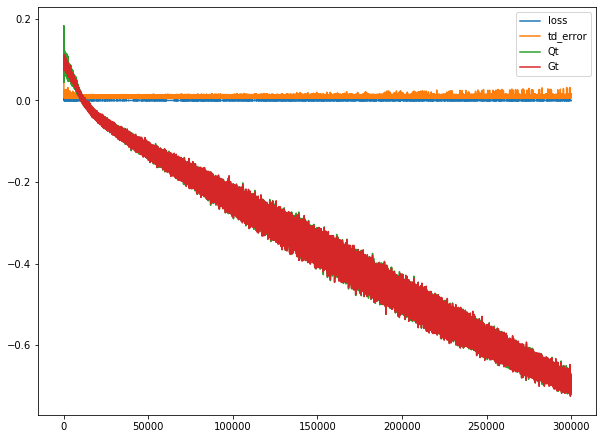

In [225]:
figsize(10, 7.5)


trn_metrics = reduce_train_metrics(list_2_dict(train_metrics), ['Qt', 'Gt'])

plt.plot(trn_metrics['loss'], label='loss')
plt.plot(trn_metrics['td_error'], label='td_error')
plt.plot(trn_metrics['Qt'], label='Qt')
plt.plot(trn_metrics['Gt'], label='Gt')
plt.legend()

dict_keys(['equity', 'returns', 'prices', 'positions', 'assets', 'cash', 'margin', 'actions', 'states', 'qvals'])


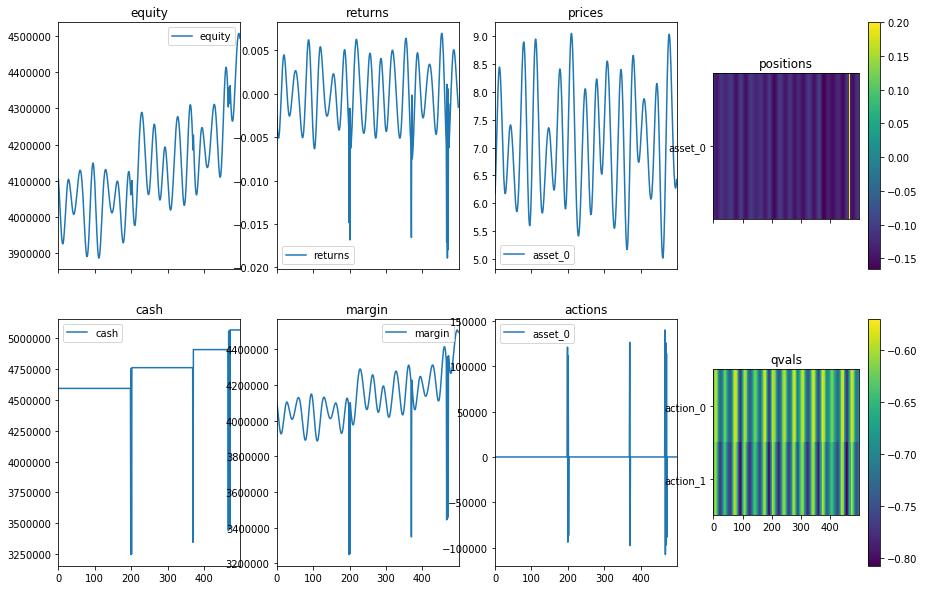

In [253]:
from madigan.utils.plotting import plot_test_metrics
# agent.model_t.load_state_dict(agent.model_b.state_dict())
figsize(15, 10)
reset=True
reset=False

tst_metrics = test(agent, env, preprocessor, 
                   nsteps=500, verbose=True, reset=reset, eps=0.)
print(tst_metrics.keys())

fig, ax = plot_test_metrics(tst_metrics)

In [ ]:
params = list(agent.model_t.parameters())
print("biases", params[1])
weights = params[0].detach().cpu().numpy()
for i in range(0, 64):    
    plt.plot(weights[i], label=str(i))
# plt.legend()

In [ ]:
perfect_agent = PerfectAgent(config)

In [ ]:
tst_metrics = test(perfect_agent, env, preprocessor, verbose=True)
print(tst_metrics.keys())
fig, ax = plot_test_metrics(tst_metrics)


In [24]:
perfect_agent.get_qvals(preprocessor.current_data()).shape

torch.Size([1, 2])

In [25]:
preprocessor.current_data().price.shape

(64, 1)